In [2]:
from collections import Counter
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
import tensorflow_hub as hub
from scipy import sparse
from gensim.parsing.preprocessing import remove_stopwords, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_short, stem_text
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
nltk.download('stopwords')
nltk.download('vader_lexicon')
!pip install gensim
!pip install tensorflow-text

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1]:
# uncomment if using google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# define stopwords
nlp = English(disable=["parser", "tagger", "ner"])
STOPWORDS = set(stopwords.words("english"))

In [11]:
def import_data(dir_path):
    # file paths
    crowd_train_posts_path = dir_path + "/crowd/train/shared_task_posts.csv"
    crowd_test_posts_path = dir_path + "/crowd/test/shared_task_posts_test.csv"
    crowd_train_labels_path = dir_path + "/crowd/train/crowd_train.csv"
    crowd_test_labels_path = dir_path + "/crowd/test/crowd_test.csv"

    # read in files
    print("...fetching data...")
    train_posts = pd.read_csv(crowd_train_posts_path)
    train_labels = pd.read_csv(crowd_train_labels_path)
    test_posts = pd.read_csv(crowd_test_posts_path)
    test_labels = pd.read_csv(crowd_test_labels_path)

    print("...preparing dataset...")
    # fix column name for test_labels
    test_labels.columns = ["user_id", "label"]
    # merge csv into datasets for train and test
    train_data = pd.merge(train_posts, train_labels, on=["user_id"])
    test_data = pd.merge(test_posts, test_labels, on=["user_id"])
    # drop rows that have NaN values for
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    # binarize labels
    train_data["label"] = train_data.label.map({"a": 0, "b": 0, "c": 0, "d": 1})
    test_data["label"] = test_data.label.map({"a": 0, "b": 0, "c": 0, "d": 1})

    # combine data
    combined_data = pd.concat([train_data, test_data])
    combined_data = combined_data.drop(
        ["post_id", "timestamp"], axis=1
    )
    print("...imported successfully.")
    print("")

    return combined_data


def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    return train_InputExamples, validation_InputExamples

   
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=350):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

def clean_post(post):
    return re.sub("[^a-zA-Z]+", " ", post).lower()


In [8]:
# import data
data = import_data('/content/drive/MyDrive/umd_reddit_suicidewatch_dataset_v2')

...fetching data...
...preparing dataset...
...imported successfully.



In [9]:
# filter subreddit
subreddit_filter = ['SuicideWatch']
data = data[data.subreddit.isin(subreddit_filter)]
data = data.drop(['subreddit'],axis=1)

In [12]:
# standardize and clean post text
data['post_body'] = data['post_body'].map(clean_post)

In [16]:
# split data into training and test groups
X = data['post_body'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, stratify = y, random_state=42, shuffle=True
)

# BERT 

In [15]:
# load bert model and bert specific preprocessing tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# create training and testing groups
train = pd.DataFrame(X_train)
train['label'] = y_train
train.columns = ['post','label']
test = pd.DataFrame(X_test)
test['label'] = y_test
test.columns = ['post','label']

In [18]:
# preprocess data for BERT
DATA_COLUMN = 'post'
LABEL_COLUMN = 'label'

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
# compile model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [21]:
# train BERT
history = model.fit(train_data, epochs=20, validation_data=validation_data, batch_size=1)

Epoch 1/20


KeyboardInterrupt: ignored

(0.0, 5.378541374206543)

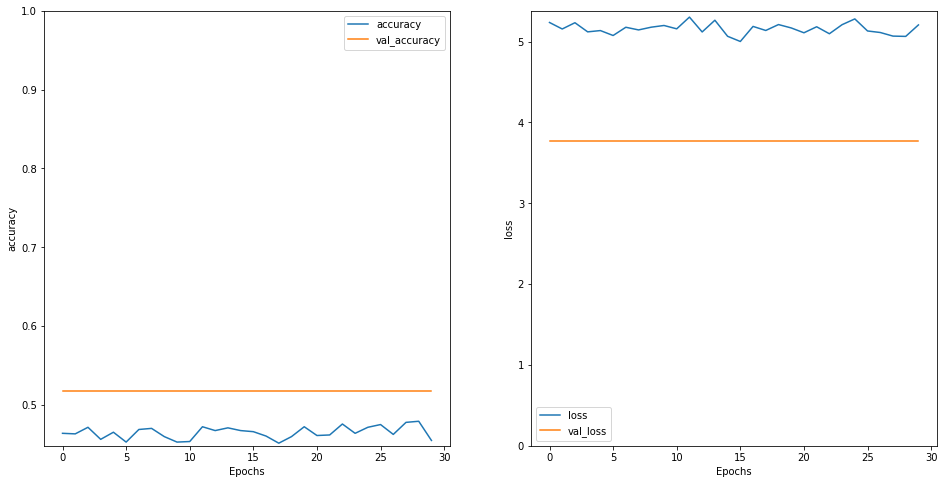

In [21]:
# visualize training performance
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# LSTM

In [22]:
# define encoder
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=80000)
encoder.adapt(X_train)
# define a vocabulary
vocab = np.array(encoder.get_vocabulary())

In [25]:
# define an LSTM model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# compile the LSTM model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_test, y_test),
                    validation_steps=30, batch_size=64)

Epoch 1/5


KeyboardInterrupt: ignored

# Pretrained Embeddings

In [3]:
# define embedding layer
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim50/2'.
INFO:absl:Downloaded https://tfhub.dev/google/nnlm-en-dim50/2, Total size: 191.83MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim50/2'.


In [47]:
# define a model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# compile it
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=[X_test, y_test])

Epoch 1/100
23/23 [==============================] - 1s 23ms/step - loss: 0.6178 - accuracy: 0.5917 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 0.1641 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0013 - accuracy: 1.0000 

In [1]:
# visualize performance
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

NameError: ignored